In [5]:
import pandas as pd

training_df = pd.read_csv('data/training_text.csv')
training_df.head(2)

,subject_id,hadm_id,admittime,discharge_location,adm_text,severity_level,note_id,disc_charttime,disc_text,Chief Complaint,...,Physical Exam,Brief Hospital Course,Medications on Admission,Discharge Medications,Discharge Disposition,Discharge Diagnosis,Discharge Condition,Discharge Instructions,Followup Instructions,training_text
0,10000032,22595853,2180-05-06 22:23:00,HOME,"Subject ID: 10000032, Hospital Admission ID: 2...",Minimal Care/Recovery at Home,10000032-DS-21,2180-05-07,"Subject ID: 10000032, HAdm ID: 22595853, Chart...",Worsening ABD distension and pain,...,VS: 98.1 107/61 78 18 97RA \nGeneral: in NAD ...,"___ HCV cirrhosis c/b ascites, hiv on ART, h/o...",The Preadmission Medication list is accurate a...,1. Albuterol Inhaler 2 PUFF IH Q4H:PRN wheezin...,Home,Ascites from Portal HTN,Mental Status: Clear and coherent.\nLevel of C...,"Dear Ms. ___,\nIt was a pleasure taking care o...",___,"Subject ID: 10000032, Hospital Admission ID: 2..."
1,10000032,22841357,2180-06-26 18:27:00,HOME,"Subject ID: 10000032, Hospital Admission ID: 2...",Minimal Care/Recovery at Home,10000032-DS-22,2180-06-27,"Subject ID: 10000032, HAdm ID: 22841357, Chart...",abdominal fullness and discomfort,...,ADMISSION PHYSICAL EXAM: \nVS: T98.1 105/57 7...,"___ with HIV on HAART, HCV cirrhosis with asci...",The Preadmission Medication list is accurate a...,"1. Acetaminophen 500 mg PO Q6H:PRN pain,fever ...",Home,Primary: diuretic refractory ascites\nSeconda...,Mental Status: Clear and coherent.\nLevel of C...,"Dear ___,\n\n___ was a pleasure to take care o...",___,"Subject ID: 10000032, Hospital Admission ID: 2..."


In [6]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

# Load your data
# Assume training_df is already prepared

# Prepare the data
X = training_df['training_text']
y = training_df['discharge_location']

# Map labels to integers
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Hugging Face dataset
train_data = pd.DataFrame({'text': X_train, 'label': y_train})
test_data = pd.DataFrame({'text': X_test, 'label': y_test})

train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))

# Tokenize the data with truncation and padding
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
results


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10221 [00:00<?, ? examples/s]

Map:   0%|          | 0/2556 [00:00<?, ? examples/s]

/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/1917 [00:00<?, ?it/s]

{'loss': 1.4283, 'grad_norm': 4.744565010070801, 'learning_rate': 1.4783515910276475e-05, 'epoch': 0.78}


  0%|          | 0/160 [00:00<?, ?it/s]

{'eval_loss': 1.2187020778656006, 'eval_runtime': 47.4683, 'eval_samples_per_second': 53.847, 'eval_steps_per_second': 3.371, 'epoch': 1.0}
{'loss': 1.2074, 'grad_norm': 5.955478668212891, 'learning_rate': 9.567031820552947e-06, 'epoch': 1.56}


  0%|          | 0/160 [00:00<?, ?it/s]

{'eval_loss': 1.1675701141357422, 'eval_runtime': 47.0741, 'eval_samples_per_second': 54.297, 'eval_steps_per_second': 3.399, 'epoch': 2.0}
{'loss': 1.105, 'grad_norm': 8.371431350708008, 'learning_rate': 4.350547730829422e-06, 'epoch': 2.35}


  0%|          | 0/160 [00:00<?, ?it/s]

{'eval_loss': 1.1573486328125, 'eval_runtime': 48.662, 'eval_samples_per_second': 52.526, 'eval_steps_per_second': 3.288, 'epoch': 3.0}
{'train_runtime': 3845.2844, 'train_samples_per_second': 7.974, 'train_steps_per_second': 0.499, 'train_loss': 1.2051059999500766, 'epoch': 3.0}


  0%|          | 0/160 [00:00<?, ?it/s]

{'eval_loss': 1.1573486328125,
 'eval_runtime': 48.6275,
 'eval_samples_per_second': 52.563,
 'eval_steps_per_second': 3.29,
 'epoch': 3.0}

In [7]:
model.save_pretrained('./results')
tokenizer.save_pretrained('./results')

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.txt',
 './results/added_tokens.json')

### Load the Trained Model

In [3]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import classification_report

# Load the saved model and tokenizer
model = BertForSequenceClassification.from_pretrained('./results')
tokenizer = BertTokenizer.from_pretrained('./results')

# Load your data
training_df = pd.read_csv('data/training_text.csv')

# Prepare the data
X = training_df['training_text']
y = training_df['discharge_location']

# Map labels to integers
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Hugging Face dataset
test_data = pd.DataFrame({'text': X_test, 'label': y_test})
test_dataset = Dataset.from_pandas(test_data)

# Tokenize the data with truncation and padding
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

test_dataset = test_dataset.map(tokenize_function, batched=True)



Map:   0%|          | 0/2556 [00:00<?, ? examples/s]

In [16]:
# Tokenize the data with truncation and padding
def tokenize_inspect(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    tokenized['original_text'] = examples['text']
    return tokenized

# Apply the tokenization function to the dataset
tokenized_dataset = test_dataset.map(tokenize_inspect, batched=True)

# Inspect a few examples
for i in range(3):  # Adjust the range to see more examples if needed
    print(f"Original text {i+1}: {tokenized_dataset[i]['original_text']}")
    print(f"Tokenized input IDs {i+1}: {tokenized_dataset[i]['input_ids']}")
    print(f"Tokenized attention mask {i+1}: {tokenized_dataset[i]['attention_mask']}\n")



Map:   0%|          | 0/2556 [00:00<?, ? examples/s]

Original text 1: Subject ID: 10469058, Hospital Admission ID: 26099851, Admission Time: 2157-07-25 14:51:00
Admission Type: EW EMER., Admission Location: EMERGENCY ROOM, Insurance: Other, Language: ENGLISH, Marital Status: SINGLE, Race: WHITE, Gender: F, Age: 45 NSTEMI Cardiac Cath (___) without stenting ___ with chest pain. Patient states her chest pain began last 
evening approximately 10 ___ and continued to worsen through the 
night. Pain is in the ___ her chest traveling to the arms 
bilaterally worse in the right arm. Pain worse when laying flat 
and not associated with any shortness of breath. Patient seen at 
outside hospital where CTA was performed concerning for small 
subsegmental pulmonary embolism and infrarenal aortic 
dissection.  Pain improved with morphine given at OSH. Troponin 
increased from undetectable to 1.9. Patient with history of 
achalasia and family history of cardiac disease. Patient smokes 
one pack per day.  Of note patient reports h/o superficial blood 


In [17]:
# Limited context window of 512
# Inspect a few examples
for i in range(3):  # Adjust the range to see more examples if needed
    print(f"Original text {i+1} length: {len(tokenized_dataset[i]['original_text'])}")
    print(f"Tokenized input IDs {i+1}: {len(tokenized_dataset[i]['input_ids'])}")
    print(f"Tokenized attention mask {i+1}: {len(tokenized_dataset[i]['attention_mask'])}\n")



Original text 1 length: 8078
Tokenized input IDs 1: 512
Tokenized attention mask 1: 512

Original text 2 length: 2432
Tokenized input IDs 2: 512
Tokenized attention mask 2: 512

Original text 3 length: 3373
Tokenized input IDs 3: 512
Tokenized attention mask 3: 512



Map:   0%|          | 0/2556 [00:00<?, ? examples/s]

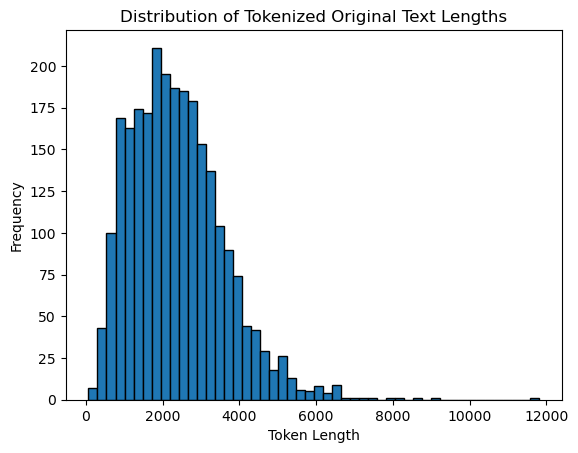

Maximum token length: 11818
Average token length: 2377.3258998435053
Median token length: 2233


In [19]:
# Tokenize the data without truncation
def tokenize_function_no_truncation(examples):
    tokenized = tokenizer(examples['text'], truncation=False, padding=False)
    tokenized['original_text'] = examples['text']  # Include the original text
    return tokenized

# Apply the tokenization function to the dataset
tokenized_dataset_no_truncation = test_dataset.map(tokenize_function_no_truncation, batched=True)

# Calculate the lengths of tokenized input IDs
tokenized_lengths_no_truncation = [len(tokenized_dataset_no_truncation[i]['input_ids']) for i in range(len(tokenized_dataset_no_truncation))]

# Plot the distribution of tokenized lengths using matplotlib
import matplotlib.pyplot as plt

plt.hist(tokenized_lengths_no_truncation, bins=50, edgecolor='black')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tokenized Original Text Lengths')
plt.show()

# Print some statistics about token lengths
print(f"Maximum token length: {max(tokenized_lengths_no_truncation)}")
print(f"Average token length: {sum(tokenized_lengths_no_truncation)/len(tokenized_lengths_no_truncation)}")
print(f"Median token length: {sorted(tokenized_lengths_no_truncation)[len(tokenized_lengths_no_truncation)//2]}")


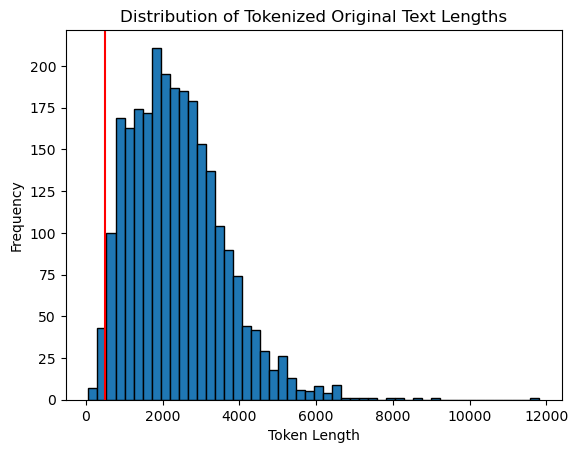

Maximum token length: 11818
Average token length: 2377.3258998435053
Median token length: 2233


In [21]:

# Plot the distribution of tokenized lengths using matplotlib
import matplotlib.pyplot as plt

plt.hist(tokenized_lengths_no_truncation, bins=50, edgecolor='black')
plt.axvline(x=512, color='red')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tokenized Original Text Lengths')
plt.show()

# Print some statistics about token lengths
print(f"Maximum token length: {max(tokenized_lengths_no_truncation)}")
print(f"Average token length: {sum(tokenized_lengths_no_truncation)/len(tokenized_lengths_no_truncation)}")
print(f"Median token length: {sorted(tokenized_lengths_no_truncation)[len(tokenized_lengths_no_truncation)//2]}")


In [5]:
# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Evaluate the model
results = trainer.evaluate()

# Display the evaluation results
print(results)

# Generate predictions on the test set
predictions = trainer.predict(test_dataset)

# Extract predicted labels
predicted_labels = predictions.predictions.argmax(axis=1)


/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/160 [00:00<?, ?it/s]

{'eval_loss': 1.1573486328125, 'eval_runtime': 47.3137, 'eval_samples_per_second': 54.022, 'eval_steps_per_second': 3.382}


  0%|          | 0/160 [00:00<?, ?it/s]

ValueError: Number of classes, 12, does not match size of target_names, 13. Try specifying the labels parameter

In [14]:

# Map the numerical labels back to the original labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
predicted_labels_str = [inverse_label_mapping[label] for label in predicted_labels]
true_labels_str = [inverse_label_mapping[label] for label in y_test]

# Create a DataFrame to compare the true and predicted labels
comparison_df = pd.DataFrame({
    'True Label': true_labels_str,
    'Predicted Label': predicted_labels_str
})

# Display the comparison
comparison_df.head()

# Generate a classification report with all possible labels
all_labels = sorted(list(inverse_label_mapping.keys()))  # <-- Change: Include all possible label indices
report = classification_report(y_test, predicted_labels, labels=all_labels, target_names=list(inverse_label_mapping.values()))  # <-- Change: Specify labels parameter

# Display the classification report
print('BERT Classifier')
print(report)

BERT Classifier
                              precision    recall  f1-score   support

                        HOME       0.73      0.77      0.75      1206
                     HOSPICE       0.00      0.00      0.00        27
            HOME HEALTH CARE       0.43      0.51      0.47       676
    SKILLED NURSING FACILITY       0.47      0.53      0.50       362
                       REHAB       0.40      0.02      0.04        95
                        DIED       0.38      0.30      0.33        71
CHRONIC/LONG TERM ACUTE CARE       0.00      0.00      0.00        60
              PSYCH FACILITY       0.40      0.11      0.17        18
              AGAINST ADVICE       0.00      0.00      0.00        19
              ACUTE HOSPITAL       0.00      0.00      0.00         7
             ASSISTED LIVING       0.00      0.00      0.00         5
         HEALTHCARE FACILITY       0.00      0.00      0.00         0
              OTHER FACILITY       0.00      0.00      0.00        10

  

/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vince/miniforge3/envs/cse251u/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

BERT classifier performs worse than baseline, probably due to limited context window. Most discharge notes are of length

5880     Subject ID: 10225793, Hospital Admission ID: 2...
12042    Subject ID: 10455855, Hospital Admission ID: 2...
7903     Subject ID: 10297774, Hospital Admission ID: 2...
12541    Subject ID: 10475876, Hospital Admission ID: 2...
565      Subject ID: 10020852, Hospital Admission ID: 2...
                               ...                        
11964    Subject ID: 10453779, Hospital Admission ID: 2...
5191     Subject ID: 10198913, Hospital Admission ID: 2...
5390     Subject ID: 10206590, Hospital Admission ID: 2...
860      Subject ID: 10031358, Hospital Admission ID: 2...
7270     Subject ID: 10276723, Hospital Admission ID: 2...
Name: training_text, Length: 10221, dtype: object

In [ ]:
df = pd.read_csv('data/discharge_journal_df.csv')

In [ ]:
import re

# Basic text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['cleaned_notes'] = df['text'].apply(clean_text)

In [ ]:
from datasets import Dataset

# Convert your DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df[['cleaned_notes']])

# Example function to tokenize and align labels
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["cleaned_notes"], truncation=True, padding="max_length", max_length=128)
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)


In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=NUMBER_OF_LABELS)

training_args = TrainingArguments(
    output_dir="./ner_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
)

trainer.train()


In [ ]:
results = trainer.evaluate()
print(results)


In [ ]:
import torch

def extract_entities_with_model(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=2)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    entities = [(tokens[i], predictions[0][i].item()) for i in range(len(tokens))]
    return entities

df['entities_finetuned'] = df['cleaned_notes'].apply(extract_entities_with_model)
